In [56]:
import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from helper_functions import reward_print, print_state_dict
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
device = "cpu"
print(device)
CUDA_LAUNCH_BLOCKING=1

ImportError: cannot import name 'print_state_dict' from 'helper_functions' (C:\Users\Dan\PycharmProjects\assignment3\helper_functions.py)

In [12]:
# AC2 algorithm 
class AC2:
    def __init__(self, env):
        self.actor = Actor(env)
        self.critic = Critic(self.actor.env.observation_space.shape[0])
    
    # Main training loop
    def train(self, episodes, gamma, greedy=False):
        total_reward = [0] * episodes
        for i in range(episodes):
            step = rewards = 0
            done = False     
            state, info = self.actor.env.reset()
            state = torch.tensor(state)
            while not done:
                # Actor makes decision 
                # Environment returns state and reward
                next_state, reward, done, action = self.actor.act(state, greedy)
                next_state = torch.tensor(next_state)#.todevice
                # Critic evaluates action 
                adv = self.critic.evaluate(state, next_state, reward, gamma ** step)
                # Pass that value to the Actor
                self.actor.evaluation(action, adv, state)
                
                state = next_state
                step += 1
                rewards += reward
                
                # Before it is done
                if done:
                    reward = 0
                    next_state = None
                    adv = self.critic.evaluate(state, next_state, reward, gamma ** step)
                    self.actor.evaluation(action, adv, state)
                
            total_reward[i] = rewards
            print("Episode:", i, " Reward", rewards)
        self.actor.env.close()
        return total_reward

               
    def save(self, filename):
        with open("pickles/" + filename + "actor.pickle", 'wb') as file:
            pickle.dump(self.actor.policy_net.state_dict(), file)
        with open("pickles/" + filename + "critic.pickle", 'wb') as file:
            pickle.dump(self.critic.policy_net.state_dict(), file)
            
    def print_state_dict(self, filename):
        

In [42]:
# Actor thread
class ActorNet(nn.Module):  
    def __init__(self, obs, act):
        super(ActorNet, self).__init__()
        self.layer1 = nn.Linear(obs, 128)
        self.layer2 = nn.Linear(128, act)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=-1)
        return x
        

class Actor:
    def __init__(self, env):
        self.env_type = env
        self.env = gym.make(env)
        self.policy_net = ActorNet(self.env.observation_space.shape[0], self.env.action_space.n)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), amsgrad=True, lr=)
    
    def act(self, state, greedy):
        # Get the weights from the policy net
        weights = self.policy_net(state)
        # if greedy get max-arg 
        if greedy: 
            action = torch.argmax(weights)
        # Use multinomial to select probability / action
        else:
            action = torch.multinomial(weights, 1)
        # Run and return the action 
        state, reward, terminated, truncated, _ = self.env.step(action.item())
        return state, reward, terminated or truncated, action

    
    def evaluation(self, action, advantage, state):
        # Get the weights from the policy 
        weight = self.policy_net(state)
        # Calculate the log probability with the weights of the 
        # current state and action and then use the adv to get the loss 
        prob = torch.distributions.Categorical(weight).log_prob(action)  
        loss = -1 * prob * advantage.detach()
        # back prop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def change_render(self, render):
        if render:
            self.env = gym.make(self.env_type, render_mode="human")
        else: 
            self.env = gym.make(self.env_type)

In [43]:
# Critic thread
class CriticNet(nn.Module):  
    def __init__(self, obs):
        super(CriticNet, self).__init__()
        self.layer1 = nn.Linear(obs, 128)
        self.layer2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return  self.layer2(x)


class Critic:
    def __init__(self, obs):
        
        self.policy_net = CriticNet(obs)
        self.optimizer = optim.AdamW(self.policy_net.parameters(),amsgrad=True )
    
    
    def evaluate(self, state, next_state, reward, gamma):
        # Get Qvalue and next Qvalue from policy         
        Qvalue = self.policy_net(state)
        if next_state is not None:
            next_Qvalue = self.policy_net(next_state)
        else: 
            next_Qvalue = 0
        
        # Calculate the TD and advantage for the next action
        TD = reward + (gamma * next_Qvalue)
        adv = Qvalue - TD
        TD = torch.tensor([TD])
        loss_function = nn.MSELoss()
        loss = loss_function(Qvalue, TD)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return adv

Episode: 0  Reward 31.0
Episode: 1  Reward 8.0
Episode: 2  Reward 13.0
Episode: 3  Reward 30.0
Episode: 4  Reward 9.0
Episode: 5  Reward 10.0
Episode: 6  Reward 21.0
Episode: 7  Reward 19.0
Episode: 8  Reward 29.0
Episode: 9  Reward 66.0
Episode: 10  Reward 9.0
Episode: 11  Reward 9.0
Episode: 12  Reward 8.0
Episode: 13  Reward 13.0
Episode: 14  Reward 10.0
Episode: 15  Reward 9.0
Episode: 16  Reward 9.0
Episode: 17  Reward 10.0
Episode: 18  Reward 12.0
Episode: 19  Reward 10.0
Episode: 20  Reward 10.0
Episode: 21  Reward 12.0
Episode: 22  Reward 14.0
Episode: 23  Reward 9.0
Episode: 24  Reward 10.0
Episode: 25  Reward 13.0
Episode: 26  Reward 11.0
Episode: 27  Reward 9.0
Episode: 28  Reward 11.0
Episode: 29  Reward 14.0
Episode: 30  Reward 10.0
Episode: 31  Reward 14.0
Episode: 32  Reward 45.0
Episode: 33  Reward 9.0
Episode: 34  Reward 13.0
Episode: 35  Reward 22.0
Episode: 36  Reward 12.0
Episode: 37  Reward 25.0
Episode: 38  Reward 14.0
Episode: 39  Reward 13.0
Episode: 40  Reward 

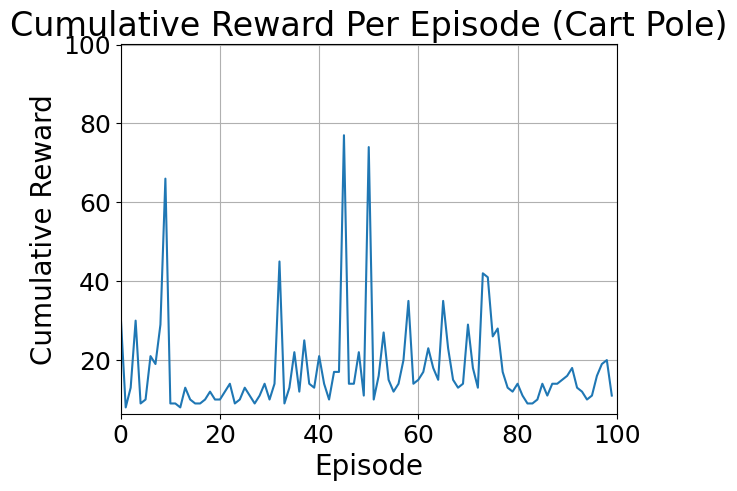

Episode: 0  Reward 8.0
Episode: 1  Reward 10.0
Episode: 2  Reward 12.0
Episode: 3  Reward 11.0
Episode: 4  Reward 13.0
Episode: 5  Reward 13.0
Episode: 6  Reward 12.0
Episode: 7  Reward 12.0
Episode: 8  Reward 11.0
Episode: 9  Reward 13.0
Episode: 10  Reward 13.0


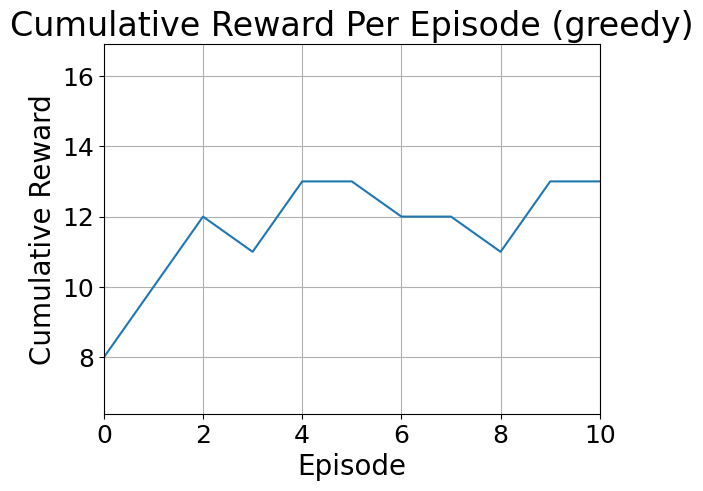

In [46]:
# AC2 Agent for Cart Pole
environment = 'CartPole-v1'
agent = AC2(environment)

episodes = 100
gamma = 1.02

agent.actor.change_render(True)

# Main training session
total_rewards = agent.train(episodes, gamma)
print("Best reward: ", max(total_rewards))
agent.save("drpreisl_CartPole")
reward_print(total_rewards, episodes, "Cart Pole")

# Greedy run 
agent.actor.change_render(True)
total_greedy_rewards = agent.train(11, gamma, greedy=True)
reward_print(total_greedy_rewards, 10, "greedy")

Episode: 0  Reward 8.0
Episode: 1  Reward 10.0
Episode: 2  Reward 10.0
Episode: 3  Reward 10.0
Episode: 4  Reward 9.0
Episode: 5  Reward 10.0
Episode: 6  Reward 8.0
Episode: 7  Reward 10.0
Episode: 8  Reward 10.0
Episode: 9  Reward 11.0
Episode: 10  Reward 10.0


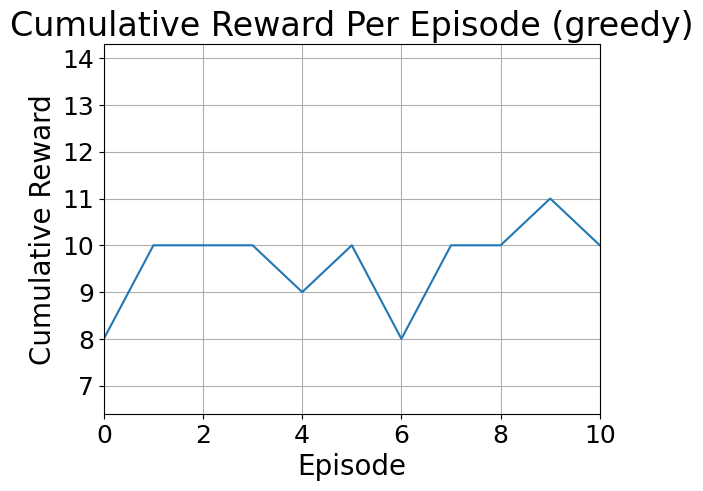

In [45]:
agent.actor.change_render(True)
total_greedy_rewards = agent.train(11, gamma, greedy=True)
reward_print(total_greedy_rewards, 10, "greedy")


In [51]:
print_Qtable(agent.actor.policy_net)

NameError: name 'device' is not defined